### Ver4 Enhanced with Spectral Attention and Multi-Objective Loss

Update di versi 4 :
- Ada Spectral Attention
- Ada Multi-Objective Loss
- Ada mekanisme early stopping
- Beberapa peningkatan di proses evaluasi

In [1]:
# ===========================================
# Cell 1. Import Library dan Setup Environment
# ===========================================

import os
import json
import random
from pathlib import Path
from collections import Counter

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from sklearn.metrics import confusion_matrix, f1_score, accuracy_score
from sklearn.preprocessing import MinMaxScaler
from scipy.ndimage import distance_transform_edt

# Gunakan GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device yang digunakan:", device)

# Monitor GPU memory
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"Total Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")


Device yang digunakan: cuda
GPU: NVIDIA GeForce RTX 4080 SUPER
Total Memory: 17.17 GB


In [2]:
# ===========================================
# Cell 2. Fungsi Bantuan Umum
# ===========================================

from matplotlib.colors import ListedColormap

def seed_everything(seed=42):
    """Menetapkan seed random agar hasil eksperimen bisa direplikasi"""
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

seed_everything(42)

def visualize_tile(x_tile, y_true=None, y_pred=None, json_path=None, class_names=None, idx=0):
    """Menampilkan citra tile beserta mask ground-truth dan prediksi"""
    if isinstance(x_tile, torch.Tensor):
        x = x_tile.cpu().numpy()
        x = np.transpose(x, (1,2,0))  # ubah dari [B,H,W] -> [H,W,B]
    else:
        x = x_tile

    # menampilkan pseudo-RGB (karena data hyperspectral)
    B = x.shape[2]
    b1, b2, b3 = int(B*0.05), int(B*0.5), int(B*0.9)
    rgb = x[..., [b1, b2, b3]]
    rgb_norm = (rgb - rgb.min()) / (rgb.max() - rgb.min() + 1e-9)

    # Coba baca colormap dari file JSON
    if json_path and os.path.exists(json_path):
        with open(json_path, "r") as f:
            label_info = json.load(f)
        custom_colors = [c["color"][:7] for c in label_info]
        cmap = ListedColormap(custom_colors)
    else:
        print("File json tidak terbaca, menggunakan cmap tab20")
        cmap = "tab20"  # fallback

    # Visualisasi
    plt.figure(figsize=(12,4))
    plt.subplot(1,3,1); plt.imshow(rgb_norm); plt.title("Citra (Pseudo-RGB)")
    if y_true is not None:
        plt.subplot(1,3,2); plt.imshow(y_true, cmap=cmap); plt.title("Ground Truth")
    if y_pred is not None:
        plt.subplot(1,3,3); plt.imshow(y_pred, cmap=cmap); plt.title("Prediksi")
    plt.tight_layout()
    plt.show()


In [3]:
# ===========================================
# Cell 3. Dataset Loader (Same as ver3)
# ===========================================

def load_label_mapping(json_path):
    """Membaca file label_classes.json untuk mapping id ke nama kelas"""
    with open(json_path, 'r', encoding='utf-8') as f:
        data = json.load(f)
    idx_to_name = {i: item["name"] for i, item in enumerate(data)}
    return idx_to_name

def normalize_reflectance(cube):
    """Menormalkan reflektansi 0-1 per tile, hemat RAM, aman untuk mmap read-only."""
    if not cube.flags.writeable:
        cube = cube.astype(np.float32, copy=True)

    if cube.dtype != np.float32:
        cube = cube.astype(np.float32, copy=False)

    np.nan_to_num(cube, copy=False)

    min_val = np.nanmin(cube)
    max_val = np.nanmax(cube)
    if max_val > min_val:
        cube -= min_val
        cube /= (max_val - min_val + 1e-8)

    return cube


class SeaweedDataset(Dataset):
    """Dataset hemat memori berbasis file .npy hasil konversi."""
    def __init__(self, data_files, label_map, tile_size=64, normalize=True, label_remap=None):
        self.data_files = data_files
        self.label_map = label_map
        self.tile_size = tile_size
        self.normalize = normalize
        self.label_remap = label_remap

        # Daftar pasangan (file_x, file_y)
        self.pairs = []
        for f in data_files:
            if f.endswith("_x.npy"):
                fy = f.replace("_x.npy", "_y.npy")
                if os.path.exists(fy):
                    self.pairs.append((f, fy))
        
        # Pre-filter tile kosong
        self.index = []
        print("[INFO] Pre-filtering empty tiles...")
        
        empty_count = 0
        valid_count = 0
        
        for file_idx, (fx, fy) in enumerate(self.pairs):
            x = np.load(fx, mmap_mode="r")
            y = np.load(fy, mmap_mode="r")
            H, W, _ = x.shape
            
            for i in range(0, H - tile_size + 1, tile_size):
                for j in range(0, W - tile_size + 1, tile_size):
                    y_tile = y[i:i+tile_size, j:j+tile_size]
                    
                    if np.any(y_tile > 0):
                        self.index.append((file_idx, i, j))
                        valid_count += 1
                    else:
                        empty_count += 1
            del x, y
            
        print(f"[INFO] Total tile valid: {valid_count}")
        print(f"[INFO] Total tile empty (filtered): {empty_count}")
        print(f"[INFO] Ratio valid/total: {valid_count/(valid_count+empty_count)*100:.2f}%")
        print(f"[INFO] Total tile terdaftar: {len(self.index)} dari {len(self.pairs)} file")

    def __len__(self):
        return len(self.index)

    def __getitem__(self, idx):
        file_idx, i, j = self.index[idx]
        fx, fy = self.pairs[file_idx]
        
        # Memuat tile menggunakan mmap
        x = np.load(fx, mmap_mode="r")[i:i+self.tile_size, j:j+self.tile_size, :]
        y = np.load(fy, mmap_mode="r")[i:i+self.tile_size, j:j+self.tile_size]

        if self.normalize:
            x = normalize_reflectance(x)

        # REMAP label bila mapping diberikan
        if self.label_remap is not None:
            y_remap = np.zeros_like(y, dtype=np.int64)
            for orig_label, new_idx in self.label_remap.items():
                y_remap[y == orig_label] = new_idx
            y = y_remap
        else:
            y = y.astype(np.int64)

        # Konversi ke tensor
        x_tensor = torch.tensor(x.transpose(2, 0, 1), dtype=torch.float32)
        y_tensor = torch.tensor(y, dtype=torch.long)
        return x_tensor, y_tensor


def detect_actual_classes(pairs):
    """Scan semua file y.npy untuk mendeteksi kelas yang benar-benar ada"""
    found = set()
    for _, fy in pairs:
        y = np.load(fy, mmap_mode="r")
        found |= set(np.unique(y))
    found = sorted(list(found))
    print(f"[INFO] Kelas AKTUAL yang ditemukan di dataset: {found}")
    return found

In [4]:
# ===========================================
# Cell 4. NOVELTY 1: Spectral Self-Attention Module
# ===========================================

class SpectralAttention(nn.Module):
    """
    Spectral Self-Attention Module
    Adaptively learns importance weights for spectral channels
    """
    def __init__(self, in_channels, reduction=16):
        super().__init__()
        # Squeeze: Global spatial pooling
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.max_pool = nn.AdaptiveMaxPool2d(1)
        
        # Excitation: Fully connected layers
        self.fc = nn.Sequential(
            nn.Linear(in_channels, in_channels // reduction, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(in_channels // reduction, in_channels, bias=False)
        )
        
        # Sigmoid activation for attention weights
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        """
        Args:
            x: [B, C, H, W] - feature map
        Returns:
            out: [B, C, H, W] - attention-weighted feature map
            attention_weights: [B, C] - learned spectral attention weights
        """
        B, C, H, W = x.size()
        
        # Squeeze: aggregate spatial information
        avg_out = self.avg_pool(x).view(B, C)
        max_out = self.max_pool(x).view(B, C)
        
        # Excitation: learn channel importance
        avg_weight = self.fc(avg_out)
        max_weight = self.fc(max_out)
        
        # Combine and normalize
        attention_weights = self.sigmoid(avg_weight + max_weight)
        
        # Apply attention
        out = x * attention_weights.view(B, C, 1, 1)
        
        return out, attention_weights

In [5]:
# ===========================================
# Cell 5. NOVELTY 2: Multi-Objective Loss Function
# ===========================================

class DiceLoss(nn.Module):
    """
    Dice Loss for region-level consistency
    Good for handling class imbalance
    """
    def __init__(self, smooth=1.0, ignore_index=0):
        super().__init__()
        self.smooth = smooth
        self.ignore_index = ignore_index
    
    def forward(self, pred, target):
        """
        Args:
            pred: [B, C, H, W] - logits
            target: [B, H, W] - ground truth
        """
        pred = F.softmax(pred, dim=1)
        target_one_hot = F.one_hot(target, num_classes=pred.shape[1]).permute(0, 3, 1, 2).float()
        
        # Ignore background
        if self.ignore_index is not None:
            mask = (target != self.ignore_index).unsqueeze(1).float()
            pred = pred * mask
            target_one_hot = target_one_hot * mask
        
        # Calculate Dice coefficient
        intersection = (pred * target_one_hot).sum(dim=(2, 3))
        union = pred.sum(dim=(2, 3)) + target_one_hot.sum(dim=(2, 3))
        
        dice = (2. * intersection + self.smooth) / (union + self.smooth)
        
        # Return 1 - Dice as loss
        return 1 - dice.mean()


class BoundaryLoss(nn.Module):
    """
    Boundary Loss for edge precision
    Penalizes errors near object boundaries
    """
    def __init__(self, ignore_index=0):
        super().__init__()
        self.ignore_index = ignore_index
    
    def forward(self, pred, target):
        """
        Args:
            pred: [B, C, H, W] - logits
            target: [B, H, W] - ground truth
        """
        pred = F.softmax(pred, dim=1)
        pred_classes = pred.argmax(dim=1)
        
        total_loss = 0
        batch_size = target.shape[0]
        
        for b in range(batch_size):
            target_np = target[b].cpu().numpy()
            pred_np = pred_classes[b].cpu().numpy()
            
            # Skip if all background
            if np.all(target_np == self.ignore_index):
                continue
            
            # Compute boundary distance transform
            boundary_target = self._compute_boundary_distance(target_np, self.ignore_index)
            boundary_pred = self._compute_boundary_distance(pred_np, self.ignore_index)
            
            # L1 distance between boundaries
            boundary_target_tensor = torch.from_numpy(boundary_target).float().to(pred.device)
            boundary_pred_tensor = torch.from_numpy(boundary_pred).float().to(pred.device)
            
            loss = torch.abs(boundary_target_tensor - boundary_pred_tensor).mean()
            total_loss += loss
        
        return total_loss / batch_size if batch_size > 0 else torch.tensor(0.0, device=pred.device)
    
    def _compute_boundary_distance(self, mask, ignore_index):
        """Compute distance transform from boundaries"""
        # Create binary mask (ignore background)
        binary_mask = (mask != ignore_index).astype(np.uint8)
        
        # Compute boundaries using morphological operations
        from scipy.ndimage import binary_erosion
        eroded = binary_erosion(binary_mask)
        boundary = binary_mask - eroded
        
        # Distance transform
        if boundary.sum() > 0:
            dist = distance_transform_edt(1 - boundary)
        else:
            dist = np.zeros_like(boundary, dtype=np.float32)
        
        return dist


class HybridLoss(nn.Module):
    """
    Multi-Objective Hybrid Loss
    Combines: Cross-Entropy + Dice + Boundary
    """
    def __init__(self, weight_ce=1.0, weight_dice=1.0, weight_boundary=0.5, 
                 class_weights=None, ignore_index=0, label_smoothing=0.1):
        super().__init__()
        self.weight_ce = weight_ce
        self.weight_dice = weight_dice
        self.weight_boundary = weight_boundary
        
        self.ce_loss = nn.CrossEntropyLoss(
            weight=class_weights, 
            ignore_index=ignore_index,
            label_smoothing=label_smoothing
        )
        self.dice_loss = DiceLoss(ignore_index=ignore_index)
        self.boundary_loss = BoundaryLoss(ignore_index=ignore_index)
    
    def forward(self, pred, target):
        """
        Args:
            pred: [B, C, H, W] - logits
            target: [B, H, W] - ground truth
        Returns:
            total_loss: weighted combination of losses
            loss_dict: individual loss components for logging
        """
        # Compute individual losses
        loss_ce = self.ce_loss(pred, target)
        loss_dice = self.dice_loss(pred, target)
        loss_boundary = self.boundary_loss(pred, target)
        
        # Weighted combination
        total_loss = (
            self.weight_ce * loss_ce +
            self.weight_dice * loss_dice +
            self.weight_boundary * loss_boundary
        )
        
        # Return dictionary for logging
        loss_dict = {
            'total': total_loss.item(),
            'ce': loss_ce.item(),
            'dice': loss_dice.item(),
            'boundary': loss_boundary.item()
        }
        
        return total_loss, loss_dict

In [6]:
# ===========================================
# Cell 6. Enhanced HybridSN with Spectral Attention
# ===========================================

class SpectralAttentionHybridSN(nn.Module):
    """
    Enhanced HybridSN with Spectral Self-Attention
    Architecture:
    1. 3D CNN for spectral-spatial feature extraction
    2. Spectral Attention Module (NOVELTY 1)
    3. 2D CNN for refined spatial processing
    4. Fully convolutional output for segmentation
    """
    def __init__(self, in_bands=300, num_classes=7, attention_reduction=16):
        super().__init__()
        
        # 3D Convolution layers
        self.conv3d_1 = nn.Conv3d(1, 16, (7,3,3), padding=(0,1,1))
        self.bn3d_1 = nn.BatchNorm3d(16)
        
        self.conv3d_2 = nn.Conv3d(16, 32, (5,3,3), padding=(0,1,1))
        self.bn3d_2 = nn.BatchNorm3d(32)
        
        self.conv3d_3 = nn.Conv3d(32, 64, (3,3,3), padding=(0,1,1))
        self.bn3d_3 = nn.BatchNorm3d(64)
        
        # Spectral pooling
        self.spectral_pool = nn.AdaptiveAvgPool3d((8, None, None))
        
        # Calculate 2D input channels
        self.flatten_channels = 64 * 8  # 512 channels
        
        # NOVELTY 1: Spectral Attention Module
        self.spectral_attention = SpectralAttention(
            in_channels=self.flatten_channels,
            reduction=attention_reduction
        )
        
        # 2D Convolution layers
        self.conv2d_1 = nn.Conv2d(self.flatten_channels, 256, 3, padding=1)
        self.bn2d_1 = nn.BatchNorm2d(256)
        self.dropout1 = nn.Dropout2d(0.3)
        
        self.conv2d_2 = nn.Conv2d(256, 128, 3, padding=1)
        self.bn2d_2 = nn.BatchNorm2d(128)
        self.dropout2 = nn.Dropout2d(0.3)
        
        self.conv2d_3 = nn.Conv2d(128, 64, 3, padding=1)
        self.bn2d_3 = nn.BatchNorm2d(64)
        
        # Classifier
        self.classifier = nn.Conv2d(64, num_classes, 1)
        
        # For attention visualization
        self.last_attention_weights = None

    def forward(self, x):
        """
        Args:
            x: [B, Bands, H, W] - input hyperspectral cube
        Returns:
            out: [B, num_classes, H, W] - segmentation logits
        """
        B, Bands, H, W = x.shape
        
        # 3D CNN processing
        x3 = x.unsqueeze(1)  # [B, 1, Bands, H, W]
        x3 = F.relu(self.bn3d_1(self.conv3d_1(x3)))
        x3 = F.relu(self.bn3d_2(self.conv3d_2(x3)))
        x3 = F.relu(self.bn3d_3(self.conv3d_3(x3)))
        
        # Spectral pooling
        x3 = self.spectral_pool(x3)  # [B, 64, 8, H, W]
        
        # Reshape to 2D
        B, C3, reduced_spec, H, W = x3.shape
        x2 = x3.view(B, C3 * reduced_spec, H, W)  # [B, 512, H, W]
        
        # NOVELTY 1: Apply Spectral Attention
        x2, attention_weights = self.spectral_attention(x2)
        self.last_attention_weights = attention_weights  # Save for visualization
        
        # 2D CNN processing
        x2 = self.dropout1(F.relu(self.bn2d_1(self.conv2d_1(x2))))
        x2 = self.dropout2(F.relu(self.bn2d_2(self.conv2d_2(x2))))
        x2 = F.relu(self.bn2d_3(self.conv2d_3(x2)))
        
        # Classification
        out = self.classifier(x2)  # [B, num_classes, H, W]
        
        return out
    
    def get_attention_weights(self):
        """Return last computed attention weights for visualization"""
        return self.last_attention_weights

In [7]:
# ===========================================
# Cell 7. Load Dataset dan Splitting
# ===========================================

data_dir = "../data/npy_converted"
label_json_path = "../data/annotation/segmentation_masks/label_classes.json"

label_map = load_label_mapping(label_json_path)
print(f"Jumlah total kelas di JSON: {len(label_map)}")

# Ambil semua file _x.npy
all_x_files = sorted([os.path.join(data_dir, f) for f in os.listdir(data_dir) if f.endswith("_x.npy")])
pairs = [(fx, fx.replace("_x.npy", "_y.npy")) for fx in all_x_files if os.path.exists(fx.replace("_x.npy", "_y.npy"))]

print(f"Total pasangan file X-Y ditemukan: {len(pairs)}")

# Split deterministik berbasis urutan nama (11 train, 5 val, 2 test)
train_pairs = pairs[:11]
val_pairs   = pairs[11:16]
test_pairs  = pairs[16:]

print("\n=== FINAL SPLIT PER FILE ===")
print(f"Train : {len(train_pairs)}")
print(f"Val   : {len(val_pairs)}")
print(f"Test  : {len(test_pairs)}")

# DETEKSI kelas aktual
actual_classes = detect_actual_classes(train_pairs + val_pairs + test_pairs)
orig_classes = [int(x) for x in actual_classes]
label_remap = {orig: idx for idx, orig in enumerate(orig_classes)}
print(f"[INFO] Label remap (orig -> new): {label_remap}")

TILE_SIZE = 32

train_dataset = SeaweedDataset([p[0] for p in train_pairs], label_map, tile_size=TILE_SIZE, label_remap=label_remap)
val_dataset   = SeaweedDataset([p[0] for p in val_pairs], label_map, tile_size=TILE_SIZE, label_remap=label_remap)
test_dataset  = SeaweedDataset([p[0] for p in test_pairs], label_map, tile_size=TILE_SIZE, label_remap=label_remap, normalize=False)

# Hitung class weights
counter = Counter()
for _, fy in train_pairs:
    y = np.load(fy, mmap_mode="r")
    for orig, new in label_remap.items():
        cnt = int((y == orig).sum())
        counter[new] += cnt

print(f"[INFO] Pixel counts per class: {dict(counter)}")

counts = np.array([counter.get(i, 0) for i in range(len(label_remap))], dtype=np.float64)
eps = 1e-6
inv_freq = 1.0 / (counts + eps)
inv_freq = inv_freq / np.mean(inv_freq)
inv_freq[0] = 0.0  # ignore background

# Apply sqrt smoothing
class_weights_np = np.sqrt(inv_freq).astype(np.float32)
print(f"[INFO] Smoothed class weights: {class_weights_np}")

num_classes_actual = len(label_remap)
print(f"\nTotal TILE train: {len(train_dataset)}, val: {len(val_dataset)}, test: {len(test_dataset)}")

Jumlah total kelas di JSON: 41
Total pasangan file X-Y ditemukan: 18

=== FINAL SPLIT PER FILE ===
Train : 11
Val   : 5
Test  : 2
[INFO] Kelas AKTUAL yang ditemukan di dataset: [np.int32(0), np.int32(8), np.int32(12), np.int32(13), np.int32(14), np.int32(18), np.int32(38)]
[INFO] Label remap (orig -> new): {0: 0, 8: 1, 12: 2, 13: 3, 14: 4, 18: 5, 38: 6}
[INFO] Pre-filtering empty tiles...
[INFO] Total tile valid: 5395
[INFO] Total tile empty (filtered): 12805
[INFO] Ratio valid/total: 29.64%
[INFO] Total tile terdaftar: 5395 dari 11 file
[INFO] Pre-filtering empty tiles...
[INFO] Total tile valid: 5698
[INFO] Total tile empty (filtered): 2898
[INFO] Ratio valid/total: 66.29%
[INFO] Total tile terdaftar: 5698 dari 5 file
[INFO] Pre-filtering empty tiles...
[INFO] Total tile valid: 1710
[INFO] Total tile empty (filtered): 950
[INFO] Ratio valid/total: 64.29%
[INFO] Total tile terdaftar: 1710 dari 2 file
[INFO] Pixel counts per class: {0: 14185638, 1: 840140, 2: 1566138, 3: 808104, 4: 369

In [8]:
# ===========================================
# Cell 8. Initialize Model with Spectral Attention
# ===========================================

# Ambil jumlah band dari data
sample_x = np.load(train_pairs[0][0], mmap_mode="r")
in_bands_actual = sample_x.shape[2]
print(f"Band input aktual: {in_bands_actual}")

# Initialize enhanced model
model = SpectralAttentionHybridSN(
    in_bands=in_bands_actual, 
    num_classes=num_classes_actual,
    attention_reduction=16
).to(device)

# Hitung parameter
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"\n{'='*60}")
print(f"MODEL ARCHITECTURE")
print(f"{'='*60}")
print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")
print(f"Model size: {total_params * 4 / 1e6:.2f} MB (float32)")
print(model)

Band input aktual: 300

MODEL ARCHITECTURE
Total parameters: 1,662,535
Trainable parameters: 1,662,535
Model size: 6.65 MB (float32)
SpectralAttentionHybridSN(
  (conv3d_1): Conv3d(1, 16, kernel_size=(7, 3, 3), stride=(1, 1, 1), padding=(0, 1, 1))
  (bn3d_1): BatchNorm3d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3d_2): Conv3d(16, 32, kernel_size=(5, 3, 3), stride=(1, 1, 1), padding=(0, 1, 1))
  (bn3d_2): BatchNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3d_3): Conv3d(32, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(0, 1, 1))
  (bn3d_3): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (spectral_pool): AdaptiveAvgPool3d(output_size=(8, None, None))
  (spectral_attention): SpectralAttention(
    (avg_pool): AdaptiveAvgPool2d(output_size=1)
    (max_pool): AdaptiveMaxPool2d(output_size=1)
    (fc): Sequential(
      (0): Linear(in_features=512, out_features=32, bias=False)
     

In [9]:
# ===========================================
# Cell 9. Setup Training with Multi-Objective Loss + Early Stopping
# ===========================================

import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau

# Enable cudnn benchmark
torch.backends.cudnn.benchmark = True

# Hyperparameters
LR = 5e-6
WEIGHT_DECAY = 1e-5
BATCH_SIZE = 1
ACCUMULATION_STEPS = 4
CLIP_NORM = 0.5

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0, pin_memory=True)

# NOVELTY 2: Multi-Objective Hybrid Loss
weight_tensor = torch.from_numpy(class_weights_np).to(device)
criterion = HybridLoss(
    weight_ce=1.0,          # Cross-Entropy weight
    weight_dice=1.0,        # Dice Loss weight
    weight_boundary=0.5,    # Boundary Loss weight
    class_weights=weight_tensor,
    ignore_index=0,
    label_smoothing=0.1
)

print("\n" + "="*60)
print("LOSS FUNCTION CONFIGURATION")
print("="*60)
print(f"Loss type: Multi-Objective Hybrid Loss")
print(f"  - Cross-Entropy weight: 1.0")
print(f"  - Dice Loss weight: 1.0")
print(f"  - Boundary Loss weight: 0.5")
print(f"  - Label smoothing: 0.1")
print(f"  - Class weights: enabled (sqrt-smoothed)")

# Optimizer & scheduler
optimizer = optim.AdamW(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY, eps=1e-8)
scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=3, verbose=True, min_lr=1e-7)

# Early Stopping Configuration
class EarlyStopping:
    """Early stopping untuk mencegah overfitting"""
    def __init__(self, patience=10, min_delta=0.0001, mode='max'):
        """
        Args:
            patience: Jumlah epoch untuk menunggu improvement
            min_delta: Minimum perubahan untuk dianggap sebagai improvement
            mode: 'max' untuk metrik yang lebih tinggi lebih baik (mIoU), 
                  'min' untuk loss
        """
        self.patience = patience
        self.min_delta = min_delta
        self.mode = mode
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.best_epoch = 0
        
    def __call__(self, current_score, epoch):
        if self.best_score is None:
            self.best_score = current_score
            self.best_epoch = epoch
            return False
        
        if self.mode == 'max':
            # Untuk mIoU: lebih tinggi lebih baik
            if current_score > self.best_score + self.min_delta:
                self.best_score = current_score
                self.counter = 0
                self.best_epoch = epoch
            else:
                self.counter += 1
        else:
            # Untuk loss: lebih rendah lebih baik
            if current_score < self.best_score - self.min_delta:
                self.best_score = current_score
                self.counter = 0
                self.best_epoch = epoch
            else:
                self.counter += 1
        
        if self.counter >= self.patience:
            self.early_stop = True
            
        return self.early_stop

# Initialize early stopping
early_stopping = EarlyStopping(patience=10, min_delta=0.0001, mode='max')

print("\n" + "="*60)
print("EARLY STOPPING CONFIGURATION")
print("="*60)
print(f"Patience: 10 epochs")
print(f"Min delta: 0.0001")
print(f"Monitoring: Validation mIoU (higher is better)")
print(f"Recommended for: 30-50 epochs training")

# Metrics class
class SegmentationMetrics:
    def __init__(self, num_classes, ignore_index=0):
        self.num_classes = num_classes
        self.ignore_index = ignore_index
        self.reset()
    
    def reset(self):
        self.total_intersection = torch.zeros(self.num_classes)
        self.total_union = torch.zeros(self.num_classes)
        self.total_correct = 0
        self.total_pixels = 0
    
    def update(self, pred, target):
        """Update metrics dengan batch baru"""
        valid = (target != self.ignore_index)
        pred = pred[valid]
        target = target[valid]
        
        # Pixel accuracy
        self.total_correct += (pred == target).sum().item()
        self.total_pixels += valid.sum().item()
        
        # IoU per class
        for cls in range(self.num_classes):
            pred_i = (pred == cls)
            target_i = (target == cls)
            intersection = (pred_i & target_i).sum().item()
            union = (pred_i | target_i).sum().item()
            
            self.total_intersection[cls] += intersection
            self.total_union[cls] += union
    
    def get_metrics(self):
        """Hitung metrik final"""
        pixel_acc = self.total_correct / (self.total_pixels + 1e-9)
        
        iou_per_class = self.total_intersection / (self.total_union + 1e-9)
        # Exclude background (index 0) dan kelas yang tidak muncul
        valid_ious = []
        for i in range(1, self.num_classes):
            if self.total_union[i] > 0:
                valid_ious.append(iou_per_class[i].item())
        
        mean_iou = np.mean(valid_ious) if valid_ious else 0.0
        
        return pixel_acc, mean_iou, iou_per_class.numpy()

print("Setup selesai!")


LOSS FUNCTION CONFIGURATION
Loss type: Multi-Objective Hybrid Loss
  - Cross-Entropy weight: 1.0
  - Dice Loss weight: 1.0
  - Boundary Loss weight: 0.5
  - Label smoothing: 0.1
  - Class weights: enabled (sqrt-smoothed)

EARLY STOPPING CONFIGURATION
Patience: 10 epochs
Min delta: 0.0001
Monitoring: Validation mIoU (higher is better)
Recommended for: 30-50 epochs training
Setup selesai!


C:\Users\admin\miniconda3\envs\algae\lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [10]:
# ===========================================
# Cell 10. Training Loop with Multi-Loss Logging + Early Stopping
# ===========================================

from tqdm import tqdm
import time

START_EPOCH = 1
NUM_EPOCHS = 50  # Increased for early stopping
best_val_miou = 0.0

checkpoint_path = "hybridsn_sgmt_ver4_checkpoint.pth"
best_model_path = "hybridsn_sgmt_ver4_best_model.pth"

# Load checkpoint jika ada
if os.path.exists(checkpoint_path):
    checkpoint = torch.load(checkpoint_path, map_location=device)
    model.load_state_dict(checkpoint["model_state"])
    optimizer.load_state_dict(checkpoint["optimizer_state"])
    START_EPOCH = checkpoint["epoch"] + 1
    best_val_miou = checkpoint.get("best_val_miou", 0.0)
    
    # Restore early stopping state
    if "early_stopping_state" in checkpoint:
        early_stopping.counter = checkpoint["early_stopping_state"]["counter"]
        early_stopping.best_score = checkpoint["early_stopping_state"]["best_score"]
        early_stopping.best_epoch = checkpoint["early_stopping_state"]["best_epoch"]
    
    print(f"[INFO] Resume dari epoch {START_EPOCH}")
    print(f"[INFO] Best mIoU so far: {best_val_miou:.4f}")
    print(f"[INFO] Early stopping counter: {early_stopping.counter}/{early_stopping.patience}")
else:
    print("[INFO] Training dari awal")

history = {
    "train_loss": [], "val_loss": [], 
    "train_acc": [], "val_acc": [], 
    "val_miou": [],
    # Multi-loss components
    "train_loss_ce": [], "train_loss_dice": [], "train_loss_boundary": [],
    "val_loss_ce": [], "val_loss_dice": [], "val_loss_boundary": []
}

def train_one_epoch(model, loader, criterion, optimizer, metrics, device):
    model.train()
    running_loss = 0.0
    running_loss_components = {'ce': 0.0, 'dice': 0.0, 'boundary': 0.0}
    metrics.reset()
    
    pbar = tqdm(loader, desc="Training", leave=False)
    optimizer.zero_grad()

    nan_count = 0
    valid_batches = 0
    
    for i, (xb, yb) in enumerate(pbar):
        xb = xb.to(device, non_blocking=True)
        yb = yb.to(device, non_blocking=True)

        # Skip jika semua background
        if torch.all(yb == 0):
            continue
        
        logits = model(xb)
        loss, loss_dict = criterion(logits, yb)
        loss = loss / ACCUMULATION_STEPS

        # Check NaN
        if torch.isnan(loss) or torch.isinf(loss):
            nan_count += 1
            continue
        
        loss.backward()
        
        # Gradient accumulation
        if (i + 1) % ACCUMULATION_STEPS == 0:
            torch.nn.utils.clip_grad_norm_(model.parameters(), CLIP_NORM)
            optimizer.step()
            optimizer.zero_grad()
        
        running_loss += loss.item() * ACCUMULATION_STEPS * xb.size(0)
        running_loss_components['ce'] += loss_dict['ce'] * xb.size(0)
        running_loss_components['dice'] += loss_dict['dice'] * xb.size(0)
        running_loss_components['boundary'] += loss_dict['boundary'] * xb.size(0)
        valid_batches += xb.size(0)
        
        preds = logits.argmax(dim=1)
        metrics.update(preds, yb)
        
        pbar.set_postfix({
            "loss": f"{loss.item()*ACCUMULATION_STEPS:.4f}",
            "ce": f"{loss_dict['ce']:.3f}",
            "dice": f"{loss_dict['dice']:.3f}",
            "bnd": f"{loss_dict['boundary']:.3f}"
        })
        
    if nan_count > 0:
        print(f"  [INFO] Skipped {nan_count} NaN batches in training")
    
    avg_loss = running_loss / valid_batches if valid_batches > 0 else 0.0
    avg_loss_ce = running_loss_components['ce'] / valid_batches if valid_batches > 0 else 0.0
    avg_loss_dice = running_loss_components['dice'] / valid_batches if valid_batches > 0 else 0.0
    avg_loss_boundary = running_loss_components['boundary'] / valid_batches if valid_batches > 0 else 0.0
    
    pixel_acc, _, _ = metrics.get_metrics()
    
    return avg_loss, pixel_acc, avg_loss_ce, avg_loss_dice, avg_loss_boundary

def validate(model, loader, criterion, metrics, device):
    model.eval()
    running_loss = 0.0
    running_loss_components = {'ce': 0.0, 'dice': 0.0, 'boundary': 0.0}
    valid_batches = 0
    metrics.reset()

    nan_count = 0
    
    with torch.no_grad():
        for xb, yb in tqdm(loader, desc="Validation", leave=False):
            xb = xb.to(device, non_blocking=True)
            yb = yb.to(device, non_blocking=True)

            # Skip jika semua background
            if torch.all(yb == 0):
                continue
            
            logits = model(xb)
            loss, loss_dict = criterion(logits, yb)

            # Check NaN
            if torch.isnan(loss) or torch.isinf(loss):
                nan_count += 1
                continue
            
            running_loss += loss.item() * xb.size(0)
            running_loss_components['ce'] += loss_dict['ce'] * xb.size(0)
            running_loss_components['dice'] += loss_dict['dice'] * xb.size(0)
            running_loss_components['boundary'] += loss_dict['boundary'] * xb.size(0)
            valid_batches += xb.size(0)
            
            preds = logits.argmax(dim=1)
            metrics.update(preds, yb)

    if nan_count > 0:
        print(f"  [INFO] Skipped {nan_count} NaN batches in validation")
    
    # Hitung average loss
    if valid_batches > 0:
        avg_loss = running_loss / valid_batches
        avg_loss_ce = running_loss_components['ce'] / valid_batches
        avg_loss_dice = running_loss_components['dice'] / valid_batches
        avg_loss_boundary = running_loss_components['boundary'] / valid_batches
    else:
        avg_loss = float('nan')
        avg_loss_ce = avg_loss_dice = avg_loss_boundary = float('nan')
        print("  [WARNING] Semua validation batches di-skip!")
    
    pixel_acc, mean_iou, iou_per_class = metrics.get_metrics()
    
    return avg_loss, pixel_acc, mean_iou, iou_per_class, avg_loss_ce, avg_loss_dice, avg_loss_boundary


# Training loop with Early Stopping
print("\n" + "="*60)
print("STARTING TRAINING WITH SPECTRAL ATTENTION & MULTI-LOSS")
print("="*60)
print(f"Max epochs: {NUM_EPOCHS}")
print(f"Early stopping patience: {early_stopping.patience} epochs")
print(f"Will stop if no improvement for {early_stopping.patience} consecutive epochs")

stopped_early = False

for epoch in range(START_EPOCH, NUM_EPOCHS + 1):
    print(f"\n{'='*60}")
    print(f"Epoch {epoch}/{NUM_EPOCHS}")
    print(f"{'='*60}")
    
    start_time = time.time()
    
    # Monitor GPU memory
    if torch.cuda.is_available():
        print(f"GPU Memory: {torch.cuda.memory_allocated()/1e9:.2f} GB allocated")
    
    # Training
    train_metrics = SegmentationMetrics(num_classes_actual, ignore_index=0)
    train_loss, train_acc, train_ce, train_dice, train_bnd = train_one_epoch(
        model, train_loader, criterion, optimizer, train_metrics, device
    )
    
    # Validation
    val_metrics = SegmentationMetrics(num_classes_actual, ignore_index=0)
    val_loss, val_acc, val_miou, val_iou_per_class, val_ce, val_dice, val_bnd = validate(
        model, val_loader, criterion, val_metrics, device
    )
    
    # Scheduler step
    scheduler.step(val_miou)
    
    # Logging
    elapsed = time.time() - start_time
    print(f"\nResults:")
    print(f"  Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")
    print(f"    ├─ CE: {train_ce:.4f} | Dice: {train_dice:.4f} | Boundary: {train_bnd:.4f}")
    print(f"  Val Loss  : {val_loss:.4f} | Val Acc  : {val_acc:.4f}")
    print(f"    ├─ CE: {val_ce:.4f} | Dice: {val_dice:.4f} | Boundary: {val_bnd:.4f}")
    print(f"  Val mIoU  : {val_miou:.4f}")
    print(f"  Time      : {elapsed/60:.2f} min")
    print(f"  IoU per class: {val_iou_per_class[1:]}")
    
    # Save history
    history["train_loss"].append(train_loss)
    history["val_loss"].append(val_loss)
    history["train_acc"].append(train_acc)
    history["val_acc"].append(val_acc)
    history["val_miou"].append(val_miou)
    history["train_loss_ce"].append(train_ce)
    history["train_loss_dice"].append(train_dice)
    history["train_loss_boundary"].append(train_bnd)
    history["val_loss_ce"].append(val_ce)
    history["val_loss_dice"].append(val_dice)
    history["val_loss_boundary"].append(val_bnd)
    
    # Checkpoint (save early stopping state)
    checkpoint = {
        "epoch": epoch,
        "model_state": model.state_dict(),
        "optimizer_state": optimizer.state_dict(),
        "scheduler_state": scheduler.state_dict(),
        "best_val_miou": best_val_miou,
        "history": history,
        "early_stopping_state": {
            "counter": early_stopping.counter,
            "best_score": early_stopping.best_score,
            "best_epoch": early_stopping.best_epoch
        }
    }
    torch.save(checkpoint, checkpoint_path)
    
    # Save best model
    if val_miou > best_val_miou:
        best_val_miou = val_miou
        torch.save(checkpoint, best_model_path)
        print(f"[OK] Best model saved! (mIoU: {best_val_miou:.4f})")
    
    # Early Stopping Check
    if early_stopping(val_miou, epoch):
        print(f"\n{'='*60}")
        print(f"EARLY STOPPING TRIGGERED!")
        print(f"{'='*60}")
        print(f"No improvement for {early_stopping.patience} consecutive epochs")
        print(f"Best validation mIoU: {early_stopping.best_score:.4f} at epoch {early_stopping.best_epoch}")
        print(f"Training stopped at epoch {epoch}")
        stopped_early = True
        break
    else:
        # Show early stopping progress
        if early_stopping.counter > 0:
            print(f"[Early Stopping] No improvement for {early_stopping.counter}/{early_stopping.patience} epochs")
            print(f"[Early Stopping] Best mIoU: {early_stopping.best_score:.4f} (epoch {early_stopping.best_epoch})")
    
    # Clear cache
    torch.cuda.empty_cache()

print("\n" + "="*60)
if stopped_early:
    print("Training stopped early!")
    print(f"Completed {epoch} epochs out of {NUM_EPOCHS} maximum")
else:
    print("Training completed all epochs!")
print(f"Best validation mIoU: {best_val_miou:.4f}")
print("="*60)

[INFO] Training dari awal

STARTING TRAINING WITH SPECTRAL ATTENTION & MULTI-LOSS
Max epochs: 50
Early stopping patience: 10 epochs
Will stop if no improvement for 10 consecutive epochs

Epoch 1/50
GPU Memory: 0.01 GB allocated



Results:
  Train Loss: 4.1940 | Train Acc: 0.3001
    ├─ CE: 1.9974 | Dice: 0.9367 | Boundary: 2.5199
  Val Loss  : 3.4526 | Val Acc  : 0.4441
    ├─ CE: 1.9026 | Dice: 0.9368 | Boundary: 1.2264
  Val mIoU  : 0.0872
  Time      : 4.74 min
  IoU per class: [0.         0.02979703 0.00223283 0.         0.         0.49129435]
[OK] Best model saved! (mIoU: 0.0872)

Epoch 2/50
GPU Memory: 0.04 GB allocated



Results:
  Train Loss: 3.6961 | Train Acc: 0.3838
    ├─ CE: 1.9092 | Dice: 0.9318 | Boundary: 1.7102
  Val Loss  : 3.4407 | Val Acc  : 0.4327
    ├─ CE: 1.8927 | Dice: 0.9348 | Boundary: 1.2264
  Val mIoU  : 0.1277
  Time      : 4.04 min
  IoU per class: [0.         0.03141335 0.00066802 0.         0.         0.47888702]
[OK] Best model saved! (mIoU: 0.1277)

Epoch 3/50
GPU Memory: 0.04 GB allocated



Results:
  Train Loss: 3.6379 | Train Acc: 0.4146
    ├─ CE: 1.8626 | Dice: 0.9286 | Boundary: 1.6935
  Val Loss  : 3.4174 | Val Acc  : 0.4649
    ├─ CE: 1.8713 | Dice: 0.9329 | Boundary: 1.2264
  Val mIoU  : 0.1344
  Time      : 4.04 min
  IoU per class: [0.         0.0273666  0.         0.         0.         0.51009434]
[OK] Best model saved! (mIoU: 0.1344)

Epoch 4/50
GPU Memory: 0.04 GB allocated



Results:
  Train Loss: 3.6014 | Train Acc: 0.4271
    ├─ CE: 1.8301 | Dice: 0.9259 | Boundary: 1.6910
  Val Loss  : 3.3845 | Val Acc  : 0.5472
    ├─ CE: 1.8408 | Dice: 0.9305 | Boundary: 1.2264
  Val mIoU  : 0.1514
  Time      : 3.98 min
  IoU per class: [0.         0.02650101 0.         0.         0.         0.57906574]
[OK] Best model saved! (mIoU: 0.1514)

Epoch 5/50
GPU Memory: 0.04 GB allocated



Results:
  Train Loss: 3.5666 | Train Acc: 0.4381
    ├─ CE: 1.7977 | Dice: 0.9233 | Boundary: 1.6912
  Val Loss  : 3.4519 | Val Acc  : 0.0395
    ├─ CE: 1.9054 | Dice: 0.9333 | Boundary: 1.2264
  Val mIoU  : 0.0155
  Time      : 4.04 min
  IoU per class: [0.         0.0344468  0.00694291 0.         0.         0.00504713]
[Early Stopping] No improvement for 1/10 epochs
[Early Stopping] Best mIoU: 0.1514 (epoch 4)

Epoch 6/50
GPU Memory: 0.04 GB allocated



Results:
  Train Loss: 3.5300 | Train Acc: 0.4756
    ├─ CE: 1.7638 | Dice: 0.9205 | Boundary: 1.6912
  Val Loss  : 3.4056 | Val Acc  : 0.1069
    ├─ CE: 1.8614 | Dice: 0.9310 | Boundary: 1.2264
  Val mIoU  : 0.0358
  Time      : 4.04 min
  IoU per class: [0.         0.03369689 0.00449783 0.         0.         0.10489025]
[Early Stopping] No improvement for 2/10 epochs
[Early Stopping] Best mIoU: 0.1514 (epoch 4)

Epoch 7/50
GPU Memory: 0.04 GB allocated



Results:
  Train Loss: 3.4878 | Train Acc: 0.5546
    ├─ CE: 1.7250 | Dice: 0.9175 | Boundary: 1.6905
  Val Loss  : 3.4372 | Val Acc  : 0.0455
    ├─ CE: 1.8909 | Dice: 0.9331 | Boundary: 1.2264
  Val mIoU  : 0.0239
  Time      : 3.97 min
  IoU per class: [0.0000000e+00 3.5537194e-02 3.6081873e-02 0.0000000e+00 0.0000000e+00
 3.9386552e-05]
[Early Stopping] No improvement for 3/10 epochs
[Early Stopping] Best mIoU: 0.1514 (epoch 4)

Epoch 8/50
GPU Memory: 0.04 GB allocated



Results:
  Train Loss: 3.4491 | Train Acc: 0.5935
    ├─ CE: 1.6891 | Dice: 0.9147 | Boundary: 1.6905
  Val Loss  : 3.4063 | Val Acc  : 0.0458
    ├─ CE: 1.8612 | Dice: 0.9319 | Boundary: 1.2264
  Val mIoU  : 0.0231
  Time      : 3.99 min
  IoU per class: [0.         0.03551524 0.03058747 0.         0.         0.00313723]
[Early Stopping] No improvement for 4/10 epochs
[Early Stopping] Best mIoU: 0.1514 (epoch 4)

Epoch 9/50
GPU Memory: 0.04 GB allocated



Results:
  Train Loss: 3.4239 | Train Acc: 0.6040
    ├─ CE: 1.6659 | Dice: 0.9127 | Boundary: 1.6905
  Val Loss  : 3.4046 | Val Acc  : 0.0478
    ├─ CE: 1.8597 | Dice: 0.9317 | Boundary: 1.2264
  Val mIoU  : 0.0221
  Time      : 3.94 min
  IoU per class: [0.         0.03555231 0.01991164 0.         0.         0.01084954]
[Early Stopping] No improvement for 5/10 epochs
[Early Stopping] Best mIoU: 0.1514 (epoch 4)

Epoch 10/50
GPU Memory: 0.04 GB allocated



Results:
  Train Loss: 3.4073 | Train Acc: 0.6122
    ├─ CE: 1.6507 | Dice: 0.9114 | Boundary: 1.6905
  Val Loss  : 3.4152 | Val Acc  : 0.0373
    ├─ CE: 1.8699 | Dice: 0.9320 | Boundary: 1.2264
  Val mIoU  : 0.0145
  Time      : 3.93 min
  IoU per class: [0.         0.0348031  0.00764702 0.         0.         0.00097255]
[Early Stopping] No improvement for 6/10 epochs
[Early Stopping] Best mIoU: 0.1514 (epoch 4)

Epoch 11/50
GPU Memory: 0.04 GB allocated



Results:
  Train Loss: 3.3927 | Train Acc: 0.6237
    ├─ CE: 1.6373 | Dice: 0.9101 | Boundary: 1.6905
  Val Loss  : 3.4115 | Val Acc  : 0.0387
    ├─ CE: 1.8669 | Dice: 0.9314 | Boundary: 1.2264
  Val mIoU  : 0.0165
  Time      : 3.99 min
  IoU per class: [0.0000000e+00 3.5044570e-02 1.4263843e-02 0.0000000e+00 0.0000000e+00
 4.1954867e-05]
[Early Stopping] No improvement for 7/10 epochs
[Early Stopping] Best mIoU: 0.1514 (epoch 4)

Epoch 12/50
GPU Memory: 0.04 GB allocated



Results:
  Train Loss: 3.3777 | Train Acc: 0.6400
    ├─ CE: 1.6235 | Dice: 0.9089 | Boundary: 1.6905
  Val Loss  : 3.3990 | Val Acc  : 0.0374
    ├─ CE: 1.8553 | Dice: 0.9305 | Boundary: 1.2264
  Val mIoU  : 0.0147
  Time      : 4.09 min
  IoU per class: [0.         0.03493296 0.00850267 0.         0.         0.00057894]
[Early Stopping] No improvement for 8/10 epochs
[Early Stopping] Best mIoU: 0.1514 (epoch 4)

Epoch 13/50
GPU Memory: 0.04 GB allocated



Results:
  Train Loss: 3.3667 | Train Acc: 0.6533
    ├─ CE: 1.6136 | Dice: 0.9079 | Boundary: 1.6905
  Val Loss  : 3.3954 | Val Acc  : 0.0396
    ├─ CE: 1.8513 | Dice: 0.9309 | Boundary: 1.2264
  Val mIoU  : 0.0166
  Time      : 4.01 min
  IoU per class: [0.         0.03509745 0.01284571 0.         0.         0.00200572]
[Early Stopping] No improvement for 9/10 epochs
[Early Stopping] Best mIoU: 0.1514 (epoch 4)

Epoch 14/50
GPU Memory: 0.04 GB allocated



Results:
  Train Loss: 3.3594 | Train Acc: 0.6647
    ├─ CE: 1.6069 | Dice: 0.9073 | Boundary: 1.6905
  Val Loss  : 3.3653 | Val Acc  : 0.0490
    ├─ CE: 1.8230 | Dice: 0.9291 | Boundary: 1.2264
  Val mIoU  : 0.0263
  Time      : 4.09 min
  IoU per class: [0.         0.03521988 0.03905136 0.         0.         0.00448216]

EARLY STOPPING TRIGGERED!
No improvement for 10 consecutive epochs
Best validation mIoU: 0.1514 at epoch 4
Training stopped at epoch 14

Training stopped early!
Completed 14 epochs out of 50 maximum
Best validation mIoU: 0.1514


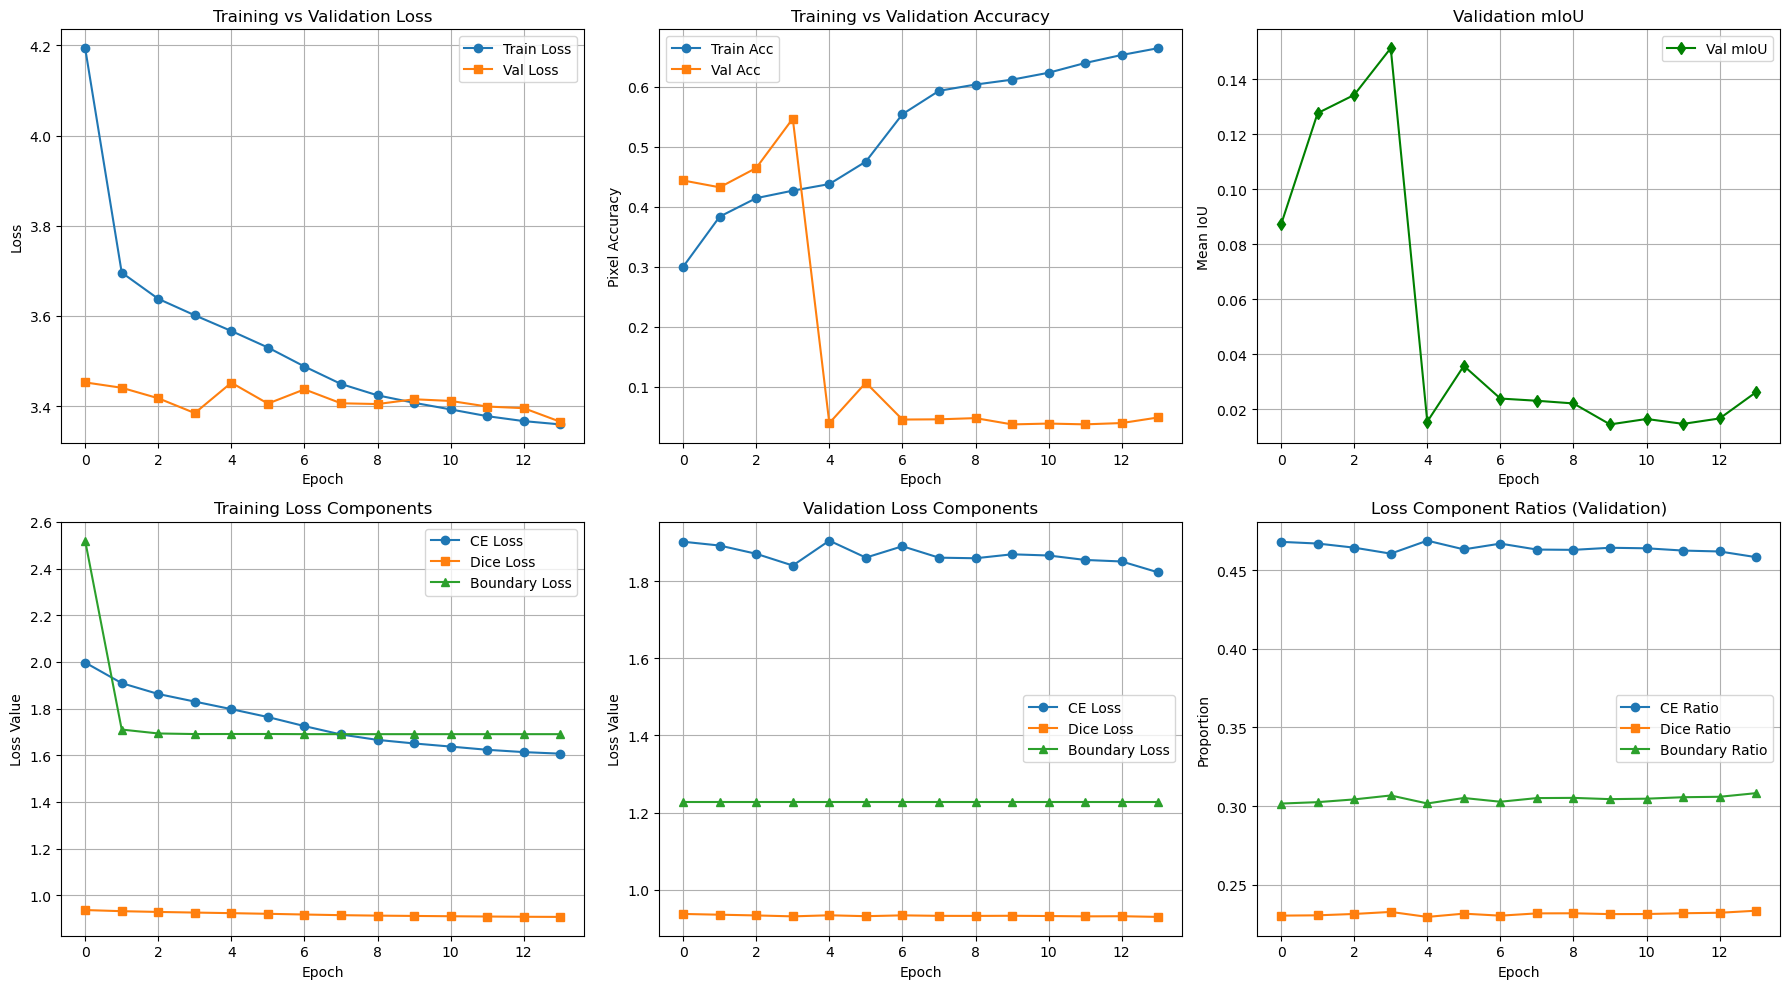

In [11]:
# ===========================================
# Cell 11. Plot Training History (Enhanced)
# ===========================================

fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# Loss
axes[0, 0].plot(history["train_loss"], label="Train Loss", marker='o')
axes[0, 0].plot(history["val_loss"], label="Val Loss", marker='s')
axes[0, 0].set_xlabel("Epoch")
axes[0, 0].set_ylabel("Loss")
axes[0, 0].set_title("Training vs Validation Loss")
axes[0, 0].legend()
axes[0, 0].grid(True)

# Accuracy
axes[0, 1].plot(history["train_acc"], label="Train Acc", marker='o')
axes[0, 1].plot(history["val_acc"], label="Val Acc", marker='s')
axes[0, 1].set_xlabel("Epoch")
axes[0, 1].set_ylabel("Pixel Accuracy")
axes[0, 1].set_title("Training vs Validation Accuracy")
axes[0, 1].legend()
axes[0, 1].grid(True)

# mIoU
axes[0, 2].plot(history["val_miou"], label="Val mIoU", marker='d', color='green')
axes[0, 2].set_xlabel("Epoch")
axes[0, 2].set_ylabel("Mean IoU")
axes[0, 2].set_title("Validation mIoU")
axes[0, 2].legend()
axes[0, 2].grid(True)

# Loss Components - Training
axes[1, 0].plot(history["train_loss_ce"], label="CE Loss", marker='o')
axes[1, 0].plot(history["train_loss_dice"], label="Dice Loss", marker='s')
axes[1, 0].plot(history["train_loss_boundary"], label="Boundary Loss", marker='^')
axes[1, 0].set_xlabel("Epoch")
axes[1, 0].set_ylabel("Loss Value")
axes[1, 0].set_title("Training Loss Components")
axes[1, 0].legend()
axes[1, 0].grid(True)

# Loss Components - Validation
axes[1, 1].plot(history["val_loss_ce"], label="CE Loss", marker='o')
axes[1, 1].plot(history["val_loss_dice"], label="Dice Loss", marker='s')
axes[1, 1].plot(history["val_loss_boundary"], label="Boundary Loss", marker='^')
axes[1, 1].set_xlabel("Epoch")
axes[1, 1].set_ylabel("Loss Value")
axes[1, 1].set_title("Validation Loss Components")
axes[1, 1].legend()
axes[1, 1].grid(True)

# Loss ratio analysis
if len(history["val_loss_ce"]) > 0:
    total = np.array(history["val_loss_ce"]) + np.array(history["val_loss_dice"]) + np.array(history["val_loss_boundary"])
    ce_ratio = np.array(history["val_loss_ce"]) / (total + 1e-9)
    dice_ratio = np.array(history["val_loss_dice"]) / (total + 1e-9)
    bnd_ratio = np.array(history["val_loss_boundary"]) / (total + 1e-9)
    
    axes[1, 2].plot(ce_ratio, label="CE Ratio", marker='o')
    axes[1, 2].plot(dice_ratio, label="Dice Ratio", marker='s')
    axes[1, 2].plot(bnd_ratio, label="Boundary Ratio", marker='^')
    axes[1, 2].set_xlabel("Epoch")
    axes[1, 2].set_ylabel("Proportion")
    axes[1, 2].set_title("Loss Component Ratios (Validation)")
    axes[1, 2].legend()
    axes[1, 2].grid(True)

plt.tight_layout()
plt.savefig("training_history_ver4_enhanced.png", dpi=150)
plt.show()


Visualizing spectral attention weights...


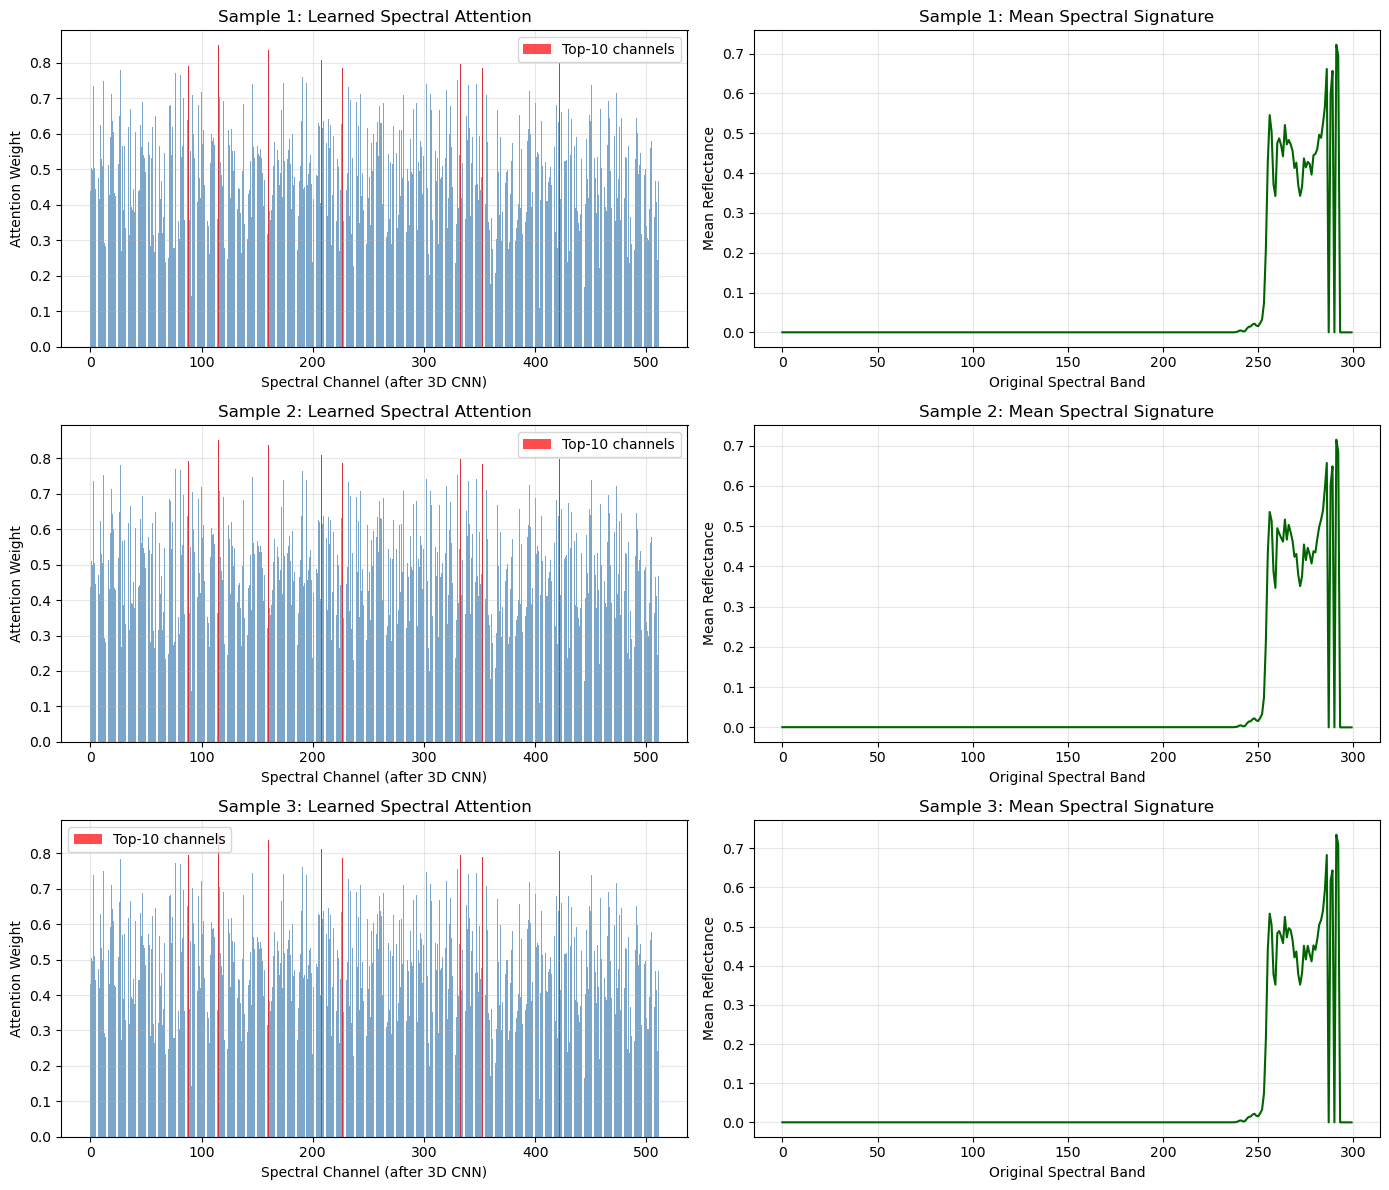


SPECTRAL ATTENTION ANALYSIS

Sample 1:
  Mean attention: 0.4951
  Std attention: 0.1408
  Max attention: 0.8491
  Top-5 channels: [309 208 399 160 115] with weights [0.8076994  0.8092338  0.8128571  0.83530164 0.8491427 ]

Sample 2:
  Mean attention: 0.4950
  Std attention: 0.1411
  Max attention: 0.8511
  Top-5 channels: [309 208 399 160 115] with weights [0.8090984  0.81096    0.8121965  0.83784443 0.8510618 ]

Sample 3:
  Mean attention: 0.4950
  Std attention: 0.1416
  Max attention: 0.8506
  Top-5 channels: [309 208 399 160 115] with weights [0.8120956  0.8129734  0.81308067 0.8365099  0.8506285 ]


In [12]:
# ===========================================
# Cell 12. Spectral Attention Visualization
# ===========================================

def visualize_spectral_attention(model, loader, num_samples=3):
    """Visualize learned spectral attention weights"""
    model.eval()
    
    attention_weights_list = []
    sample_images = []
    
    with torch.no_grad():
        for i, (xb, yb) in enumerate(loader):
            if i >= num_samples:
                break
            
            xb = xb.to(device)
            _ = model(xb)  # Forward pass
            
            # Get attention weights
            attn_weights = model.get_attention_weights()
            if attn_weights is not None:
                attention_weights_list.append(attn_weights[0].cpu().numpy())
                sample_images.append(xb[0])
    
    if not attention_weights_list:
        print("No attention weights captured!")
        return
    
    # Plot attention weights
    fig, axes = plt.subplots(num_samples, 2, figsize=(14, 4*num_samples))
    
    for i in range(num_samples):
        # Attention weights
        attn = attention_weights_list[i]
        axes[i, 0].bar(range(len(attn)), attn, color='steelblue', alpha=0.7)
        axes[i, 0].set_xlabel("Spectral Channel (after 3D CNN)")
        axes[i, 0].set_ylabel("Attention Weight")
        axes[i, 0].set_title(f"Sample {i+1}: Learned Spectral Attention")
        axes[i, 0].grid(True, alpha=0.3)
        
        # Top-k important channels
        top_k = 10
        top_indices = np.argsort(attn)[-top_k:]
        axes[i, 0].bar(top_indices, attn[top_indices], color='red', alpha=0.7, 
                       label=f'Top-{top_k} channels')
        axes[i, 0].legend()
        
        # Original hyperspectral signature (averaged)
        img = sample_images[i].cpu().numpy()  # [Bands, H, W]
        mean_spectrum = img.mean(axis=(1, 2))
        
        axes[i, 1].plot(mean_spectrum, color='darkgreen', linewidth=1.5)
        axes[i, 1].set_xlabel("Original Spectral Band")
        axes[i, 1].set_ylabel("Mean Reflectance")
        axes[i, 1].set_title(f"Sample {i+1}: Mean Spectral Signature")
        axes[i, 1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig("spectral_attention_weights_ver4.png", dpi=150)
    plt.show()
    
    # Print statistics
    print("\n" + "="*60)
    print("SPECTRAL ATTENTION ANALYSIS")
    print("="*60)
    for i, attn in enumerate(attention_weights_list):
        top_5_idx = np.argsort(attn)[-5:]
        print(f"\nSample {i+1}:")
        print(f"  Mean attention: {attn.mean():.4f}")
        print(f"  Std attention: {attn.std():.4f}")
        print(f"  Max attention: {attn.max():.4f}")
        print(f"  Top-5 channels: {top_5_idx} with weights {attn[top_5_idx]}")

# Visualize attention on validation set
print("\nVisualizing spectral attention weights...")
visualize_spectral_attention(model, val_loader, num_samples=3)

C:\Users\admin\AppData\Local\Temp\ipykernel_12728\3134229078.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_checkpoint = torch.load(best_model_path, map_location=d

Loaded best model from epoch 4



TEST RESULTS
Test Loss     : 3.0954
  ├─ CE Loss  : 1.9941
  ├─ Dice Loss: 0.9439
  └─ Bnd Loss : 0.3148
Test Accuracy : 0.3564
Test mIoU     : 0.0916
IoU per class : [0.00091196 0.         0.         0.         0.         0.36547685]

GENERATING SEGMENTATION MAPS
Sample 1: Input shape torch.Size([1, 300, 32, 32]), Output shape torch.Size([1, 32, 32])
Sample 2: Input shape torch.Size([1, 300, 32, 32]), Output shape torch.Size([1, 32, 32])
Sample 3: Input shape torch.Size([1, 300, 32, 32]), Output shape torch.Size([1, 32, 32])
Sample 4: Input shape torch.Size([1, 300, 32, 32]), Output shape torch.Size([1, 32, 32])
Sample 5: Input shape torch.Size([1, 300, 32, 32]), Output shape torch.Size([1, 32, 32])

Generating visualizations...
Visualizing sample 1/5


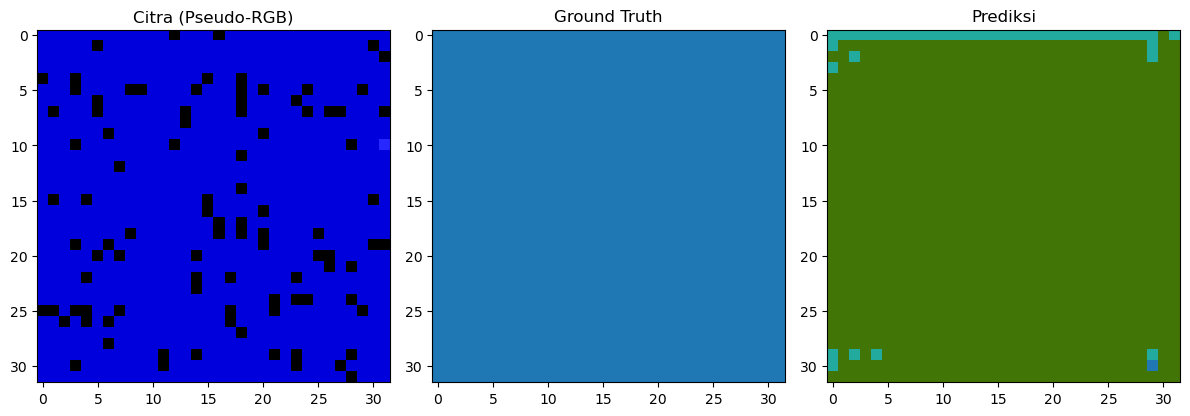

Visualizing sample 2/5


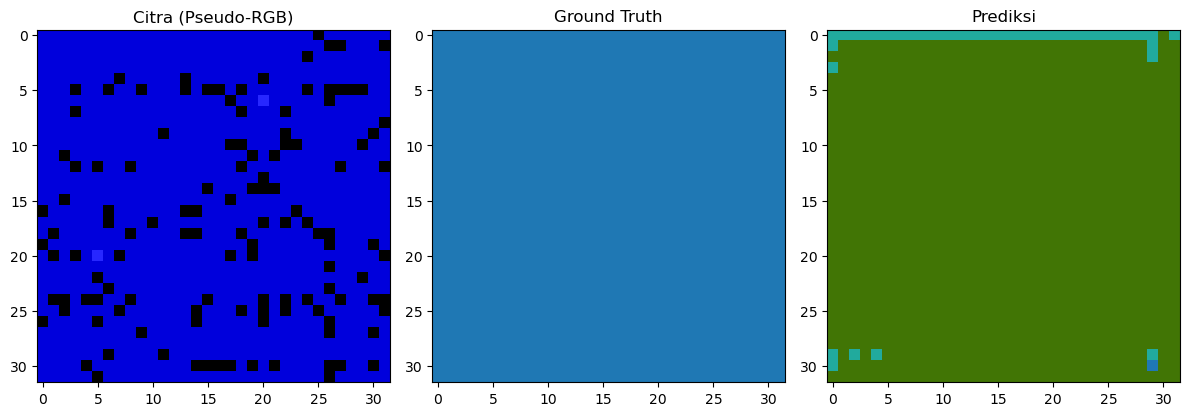

Visualizing sample 3/5


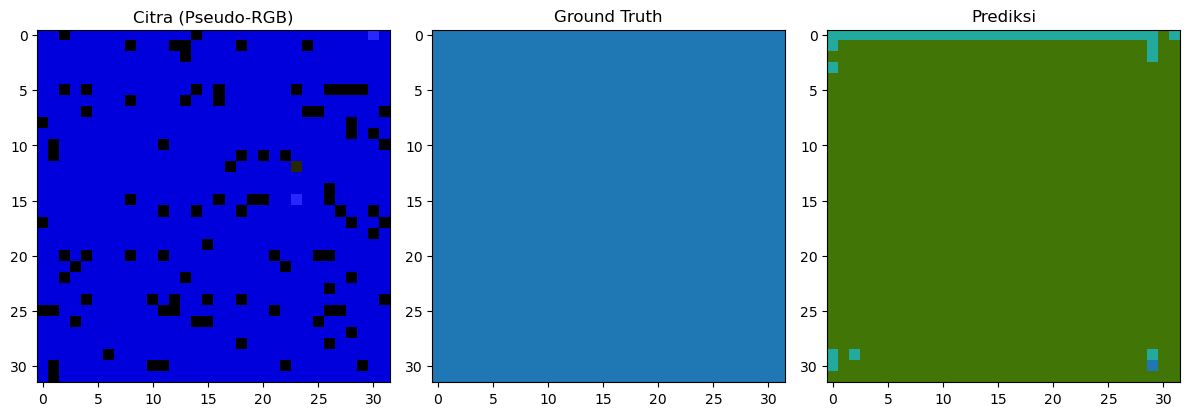

Visualizing sample 4/5


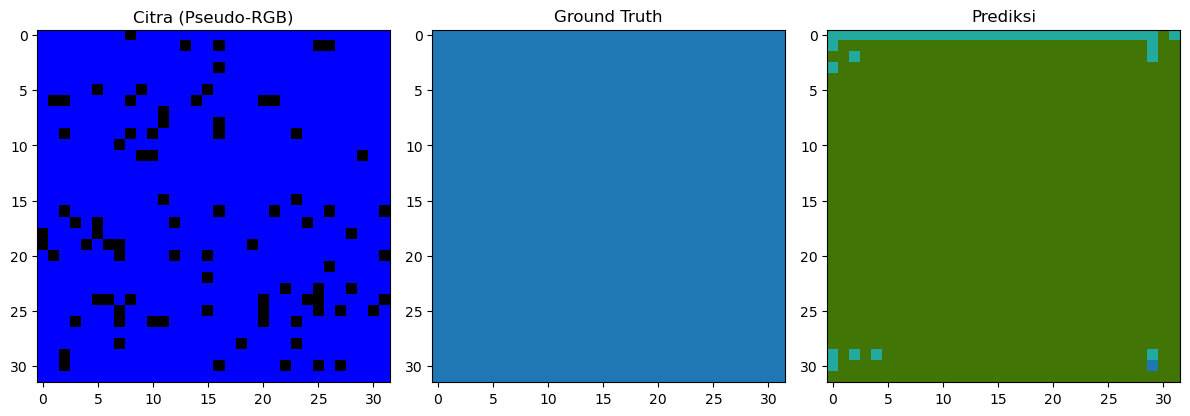

Visualizing sample 5/5


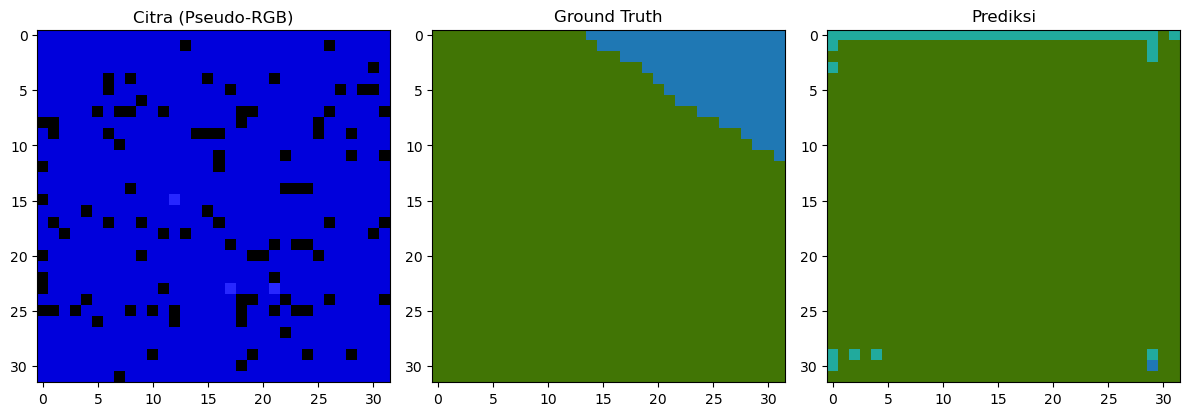


[OK] Output: SEGMENTATION MAPS
  Format: [H, W] dengan setiap pixel berisi class label (0-6)
  Visualisasi: Setiap warna merepresentasikan habitat class berbeda


In [13]:
# ===========================================
# Cell 13. Testing dan Visualisasi Output Segmentation
# ===========================================

# Load best model
best_checkpoint = torch.load(best_model_path, map_location=device)
model.load_state_dict(best_checkpoint["model_state"])
print(f"Loaded best model from epoch {best_checkpoint['epoch']}")

# Test evaluation
test_metrics = SegmentationMetrics(num_classes_actual, ignore_index=0)
test_loss, test_acc, test_miou, test_iou_per_class, test_ce, test_dice, test_bnd = validate(
    model, test_loader, criterion, test_metrics, device
)

print("\n" + "="*60)
print("TEST RESULTS")
print("="*60)
print(f"Test Loss     : {test_loss:.4f}")
print(f"  ├─ CE Loss  : {test_ce:.4f}")
print(f"  ├─ Dice Loss: {test_dice:.4f}")
print(f"  └─ Bnd Loss : {test_bnd:.4f}")
print(f"Test Accuracy : {test_acc:.4f}")
print(f"Test mIoU     : {test_miou:.4f}")
print(f"IoU per class : {test_iou_per_class[1:]}")

# Visualisasi beberapa prediksi SEGMENTATION MAP
model.eval()
num_vis = 5
vis_samples = []

print("\n" + "="*60)
print("GENERATING SEGMENTATION MAPS")
print("="*60)

with torch.no_grad():
    for i, (xb, yb) in enumerate(test_loader):
        if i >= num_vis:
            break
        xb = xb.to(device)
        logits = model(xb)
        preds = logits.argmax(dim=1)  # [B, H, W] - SEGMENTATION MAP
        
        vis_samples.append((xb[0], yb[0], preds[0]))
        print(f"Sample {i+1}: Input shape {xb.shape}, Output shape {preds.shape}")

# Plot visualisasi segmentation maps
print("\nGenerating visualizations...")
for i, (x, y_true, y_pred) in enumerate(vis_samples):
    print(f"Visualizing sample {i+1}/{num_vis}")
    visualize_tile(x, y_true.cpu().numpy(), y_pred.cpu().numpy(), 
                   json_path=label_json_path, idx=i)

print("\n[OK] Output: SEGMENTATION MAPS")
print("  Format: [H, W] dengan setiap pixel berisi class label (0-6)")
print("  Visualisasi: Setiap warna merepresentasikan habitat class berbeda")

Computing CM: 100%|███████████████████████████████████████████████████████████████| 1710/1710 [00:11<00:00, 153.13it/s]


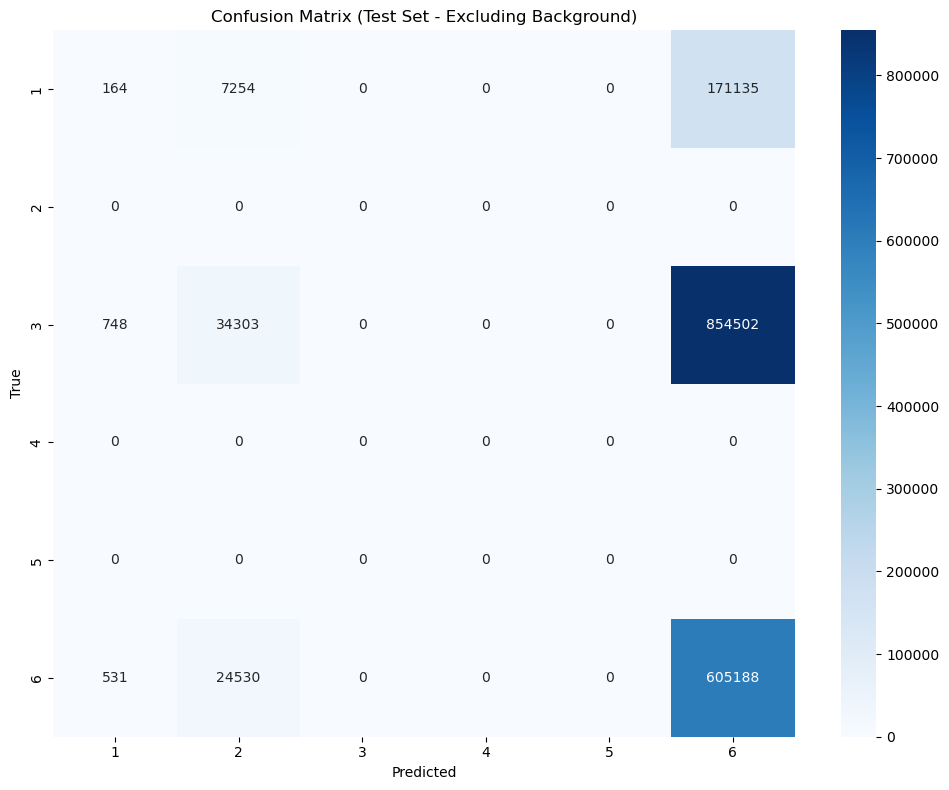

Confusion matrix saved!


In [14]:
# ===========================================
# Cell 14. Confusion Matrix
# ===========================================

from sklearn.metrics import confusion_matrix
import seaborn as sns

# Collect predictions untuk confusion matrix
all_preds = []
all_targets = []

model.eval()
with torch.no_grad():
    for xb, yb in tqdm(test_loader, desc="Computing CM"):
        xb = xb.to(device)
        logits = model(xb)
        preds = logits.argmax(dim=1)
        
        # Flatten dan filter valid pixels
        preds_flat = preds.cpu().numpy().flatten()
        targets_flat = yb.numpy().flatten()
        
        valid = targets_flat != 0  # Exclude background
        all_preds.extend(preds_flat[valid])
        all_targets.extend(targets_flat[valid])

# Compute confusion matrix
cm = confusion_matrix(all_targets, all_preds, labels=list(range(1, num_classes_actual)))

# Plot
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=range(1, num_classes_actual),
            yticklabels=range(1, num_classes_actual))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix (Test Set - Excluding Background)')
plt.tight_layout()
plt.savefig('confusion_matrix_ver4.png', dpi=150)
plt.show()

print("Confusion matrix saved!")

In [15]:
# ===========================================
# Save Results Summary
# ===========================================

results_summary = {
    "model": "SpectralAttentionHybridSN",
    "novelties": ["Spectral Self-Attention", "Multi-Objective Loss (CE+Dice+Boundary)"],
    "hyperparameters": {
        "learning_rate": LR,
        "batch_size": BATCH_SIZE,
        "accumulation_steps": ACCUMULATION_STEPS,
        "tile_size": TILE_SIZE,
        "num_epochs": NUM_EPOCHS,
        "attention_reduction": 16,
        "loss_weights": {"ce": 1.0, "dice": 1.0, "boundary": 0.5}
    },
    "test_results": {
        "pixel_accuracy": float(test_acc),
        "mean_iou": float(test_miou),
        "loss_total": float(test_loss),
        "loss_ce": float(test_ce),
        "loss_dice": float(test_dice),
        "loss_boundary": float(test_bnd),
        "iou_per_class": test_iou_per_class.tolist()
    },
    "training_history": history
}

# Save to JSON
with open("results_ver4_summary.json", "w") as f:
    json.dump(results_summary, f, indent=2)

print("\n" + "="*60)
print("EXPERIMENT SUMMARY")
print("="*60)
print(json.dumps(results_summary["test_results"], indent=2))
print("\nResults saved to: results_ver4_summary.json")
print("\n[OK] Training complete!")
print("[OK] All visualizations saved!")
print("[OK] Ready for paper writing!")



EXPERIMENT SUMMARY
{
  "pixel_accuracy": 0.3564343143806799,
  "mean_iou": 0.09159720224852208,
  "loss_total": 3.0953721853724696,
  "loss_ce": 1.9940645216501247,
  "loss_dice": 0.9439190355657834,
  "loss_boundary": 0.3147772574772764,
  "iou_per_class": [
    0.0,
    0.0009119622991420329,
    0.0,
    0.0,
    0.0,
    0.0,
    0.3654768466949463
  ]
}

Results saved to: results_ver4_summary.json

[OK] Training complete!
[OK] All visualizations saved!
[OK] Ready for paper writing!
